# Image Caption Generator

We will be using:-
* Inceptionnet v3 -> Transfer Learning
* Glove Embeddings
* Encoder - Decoder Architecture
* RNN - LSTM


## Flow of the Architecture

* The encoder model will combine both the encoded version of the image and the encoded version of the text caption and feed it to the decoder.
* We are treating the CNN model as the 'Image Model' and LSTM model as the 'Language Model' to encode text.
* The vectors resulted from both the encodings aremerged ans processed by a Dense Layer to make the final prediction


---
* We will use a concatenate/merge layer to keep images and text seperate and train the neural network seperately.
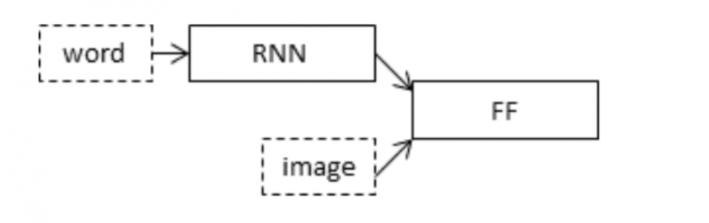


> By merging the image features and text encodings at a later stage in the architecture we can generate better quality captions with a smaller layer architecture

## Image Encoder
* We will use InceptionV3 to encode our image features.
* InceptionV3 is a highly efficient model with lower number of parameters to train

## Text Encoder
* To encode our text sequence we will map every word to a 200 dim vector.
* We will use a pretrained Glove model.
* Mapping will be done in a separate layer after the input layer called the embedding layer
> We will be using two methods to generate the captions
> * Greedy Search 
> * Beam Search

# Dataset
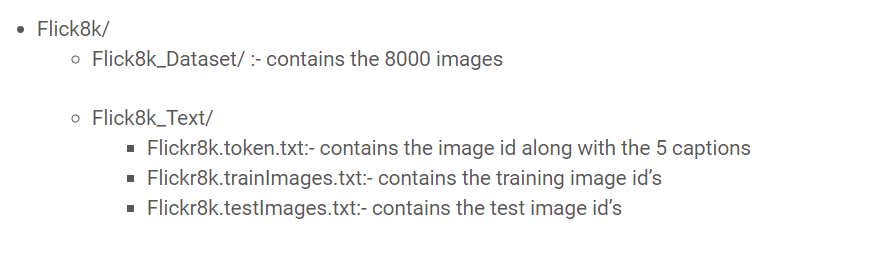

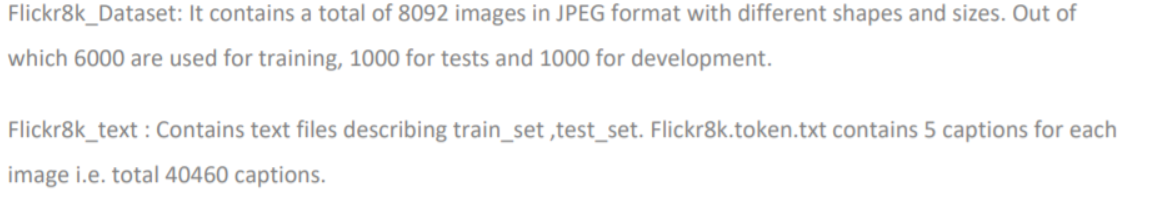

In [1]:
# Import all Libraries
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

import tensorflow as tf
from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

# Data loading and Preprocessing

###Load the captions

In [2]:
import os
captions_folder_all = '/captions/'
if not os.path.exists(os.path.abspath('.') + captions_folder_all):
  #download zip file and extract the data
  annotation_zip_file = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                                          extract = True)
  all_captions = os.path.dirname(annotation_zip_file)+'/Flickr8k.token.txt'
  train_captions = os.path.dirname(annotation_zip_file)+'/Flickr_8k.trainImages.txt'
  test_captions = os.path.dirname(annotation_zip_file)+'/Flickr_8k.devImages.txt'
  os.remove(annotation_zip_file)

2342912/2340801 [==============================] - 0s 0us/step


###Load the images


In [3]:
captions_folder_all = '/images/'
if not os.path.exists(os.path.abspath('.') + captions_folder_all):
  #download zip file and extract the data
  images_zip_file = tf.keras.utils.get_file('images.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                                          extract = True)
  all_images = os.path.dirname(images_zip_file)+'/Flicker8k_Dataset'
  os.remove(images_zip_file)

1115422720/1115419746 [==============================] - 13s 0us/step


In [4]:
token_path = "/content/Flickr8k.token.txt"
train_images_path = '/content/Flickr_8k.trainImages.txt'
test_images_path = '/content/Flickr_8k.testImages.txt'
images_path = '/content/Flicker8k_Dataset/'
glove_path = '/content/drive/MyDrive/Datasets/'

doc = open(token_path,'r').read()
print(doc[:390])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going i


Create dictionary 'descriptions' which contains the name of the image as keys and the corresponding captions as values

In [5]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [6]:
descriptions['2088120475_d6318364f5']

['A person dressed up as a snowman is walking through a crowd of people .',
 'five cold people in the snowstorm , one wearing a snowman head',
 'People pose for a picture in the snow',
 'Three young people pose by a snowman in a red tie .',
 'Two couples pose with a snowman .']

Basic Text Cleaning
* Getting rid of punctuation and to lower case 

In [7]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

In [8]:
descriptions['2088120475_d6318364f5']

['a person dressed up as a snowman is walking through a crowd of people ',
 'five cold people in the snowstorm  one wearing a snowman head',
 'people pose for a picture in the snow',
 'three young people pose by a snowman in a red tie ',
 'two couples pose with a snowman ']

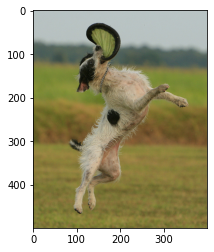

['a dog catches a frisbee in midair ',
 'a dog catching a frisbee ',
 'a terrier mix catches a frisbee in the air ',
 'a white and black dog catching a frisbee ',
 'a white dog is leaping in the air with a green object in its mouth ']

In [9]:
# Plot image and read the captions
pic = '2294598473_40637b5c04.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['2294598473_40637b5c04']

We will create a vocabulary of all the unique words in each caption of every image.
* 8000*5 -> 40000 captions in the dataset
* We have 8828 unique words across all the image captions

In [10]:
vocabulary = set()
for key in descriptions.keys():
  [vocabulary.update(d.split()) for d in descriptions[key]]
print(f'The size of the Original Vocabulary :{len(vocabulary)}')

The size of the Original Vocabulary :8828


In [11]:
list(vocabulary)[:10]

['negotiates',
 'chainmail',
 'scrolled',
 'pointing',
 'ragged',
 'boat',
 'boardedup',
 'roses',
 'posign',
 'canyon']

> Save the image id’s and their new cleaned captions in the same format as the token.txt file

In [12]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [13]:
new_descriptions[:400]

'1000268201_693b08cb0e a child in a pink dress is climbing up a set of stairs in an entry way \n1000268201_693b08cb0e a girl going into a wooden building \n1000268201_693b08cb0e a little girl climbing into a wooden playhouse \n1000268201_693b08cb0e a little girl climbing the stairs to her playhouse \n1000268201_693b08cb0e a little girl in a pink dress going into a wooden cabin \n1001773457_577c3a7d70 a '

> Load all the ~6000 training images from the ‘Flickr_8k.trainImages.txt’ file

In [14]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [15]:
list(train)[:10]

['3164347907_2813f8ff0b',
 '2862469183_a4334b904a',
 '1332815795_8eea44375e',
 '177302997_5b2d770a0a',
 '892340814_bdd61e10a4',
 '2657663775_bc98bf67ac',
 '2992999413_018f48aabc',
 '3173928684_4ea0ee5114',
 '3092756650_557c5f2d03',
 '133905560_9d012b47f3']

In [16]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [17]:
train_img[:5]

['/content/Flicker8k_Dataset/1115565519_d976d4b1f1.jpg',
 '/content/Flicker8k_Dataset/537390477_7dd3407f96.jpg',
 '/content/Flicker8k_Dataset/3437781040_82b06facb3.jpg',
 '/content/Flicker8k_Dataset/3229730008_63f8ca2de2.jpg',
 '/content/Flicker8k_Dataset/519061891_320061864e.jpg']

In [18]:
list(train_images)[:5]

['3563924606_5914392cd8.jpg',
 '3672940355_47f30e2b28.jpg',
 '3086790344_9487c58624.jpg',
 '2831215155_07ba8f1805.jpg',
 '2191329761_3effd856c5.jpg']

> We load the descriptions of the training images into a dictionary. However, we will add two tokens in every caption, which are ‘startseq’ and ‘endseq

In [19]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

>  a list of all the training captions

In [20]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [21]:
all_train_captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

> To make our model more robust we will reduce our vocabulary to only those words which occur at least 10 times in the entire corpus

In [22]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab))) 

Vocabulary = 1659


> Create two dictionaries to map words to an index and vice versa

In [23]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [24]:
ixtoword[907]

'bearded'

In [25]:
wordtoix['bearded']

907

>  Find out what the max length of a caption can be since we cannot have captions of arbitrary length.

In [26]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Max Length: %d' % max_length)

Description Max Length: 38


## Glove Embeddings

> Word vectors map words to a vector space, where similar words are clustered together and different words are separated

* The advantage of using Glove over Word2Vec is that GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors.

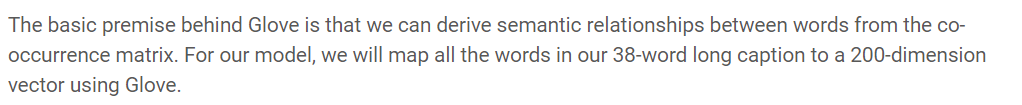

In [27]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

> We make the matrix of shape (1660,200) consisting of our vocabulary and the 200-d vector.

In [28]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Model Building and Training

In [29]:
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 1s 0us/step


> We remove the softmax layer from the inceptionV3 model

In [30]:
model_new = Model(model.input, model.layers[-2].output)

> For InceptionV3 we need to pre-process our input before feeding it into the model. We define a preprocess function to reshape the images to (299 x 299) and feed to the preprocess_input() function of Keras

In [31]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

> Encode our training and testing images, i.e extract the images vectors of shape (2048,)

In [32]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

### We are creating a Merge/Concatenated model where we combine the image vector and the partial caption.

3 Main Steps are:-
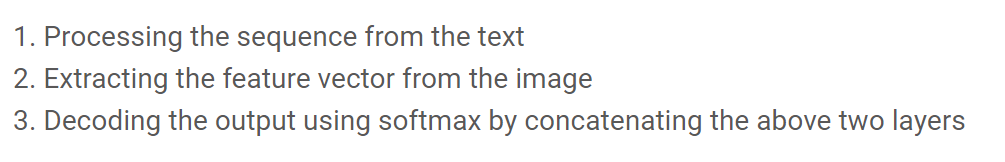

In [41]:
vocab_size, embedding_dim,max_length

(1660, 200, 38)

In [33]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

Input_3 is the partial caption of max length 34 which is fed into the embedding layer. This is where the words are mapped to the 200-d Glove embedding. It is followed by a dropout of 0.5 to avoid overfitting. This is then fed into the LSTM for processing the sequence.

Input_2 is the image vector extracted by our InceptionV3 network. It is followed by a dropout of 0.5 to avoid overfitting and then fed into a Fully Connected layer.

Both the Image model and the Language model are then concatenated by adding and fed into another Fully Connected layer. The layer is a softmax layer that provides probabilities to our 1660 word vocabulary.

## Model Training

Do not retrain the weights in our embedding layer (pre-trained Glove vectors)

In [34]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [35]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

As our dataset has 6000 images and 40000 captions we will create a function that can train the data in batches

In [36]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [46]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.33,
                              patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='loss', patience=4)
callbacks = [reduce_lr,early_stop]

In [47]:
epochs = 20
batch_size = 5
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1,callbacks = callbacks)

Epoch 1/20
1200/1200 [==============================] - 134s 112ms/step - loss: 2.7704
Epoch 2/20
1200/1200 [==============================] - 135s 112ms/step - loss: 2.6749
Epoch 3/20
1200/1200 [==============================] - 135s 113ms/step - loss: 2.6007
Epoch 4/20
1200/1200 [==============================] - 136s 113ms/step - loss: 2.5382
Epoch 5/20
1200/1200 [==============================] - 135s 113ms/step - loss: 2.4891
Epoch 6/20
1200/1200 [==============================] - 136s 114ms/step - loss: 2.4473
Epoch 7/20
1200/1200 [==============================] - 136s 113ms/step - loss: 2.4109
Epoch 8/20
1200/1200 [==============================] - 134s 112ms/step - loss: 2.3783
Epoch 9/20
1200/1200 [==============================] - 135s 113ms/step - loss: 2.3498
Epoch 10/20
1200/1200 [==============================] - 138s 115ms/step - loss: 2.3224
Epoch 11/20
1200/1200 [==============================] - 136s 114ms/step - loss: 2.3023
Epoch 12/20
1200/1200 [==================

## Greedy and Beam Search

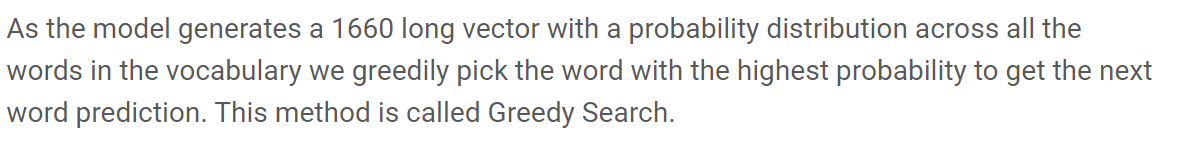

In [48]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

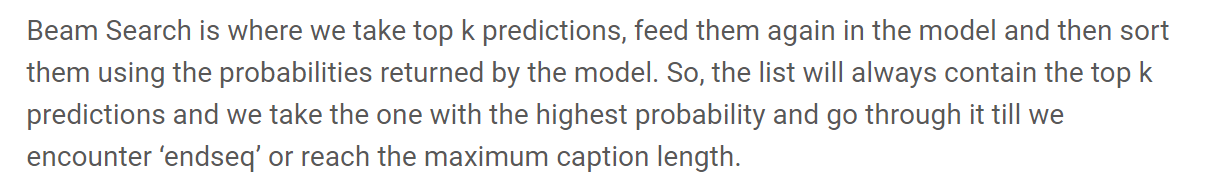

In [49]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

# Evaluation

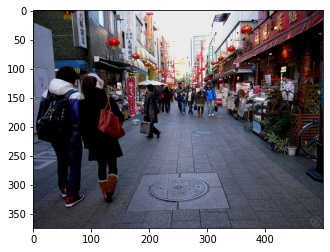

Greedy Search: a woman in a red shirt walks down a busy street
Beam Search, K = 3: a group of people shop in a city intersection
Beam Search, K = 5: a group of people standing in front of a store in a city intersection
Beam Search, K = 7: a group of people are standing outside of a store
Beam Search, K = 10: a group of people are standing outside of a store


In [53]:
pic = '3286822339_5535af6b93.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

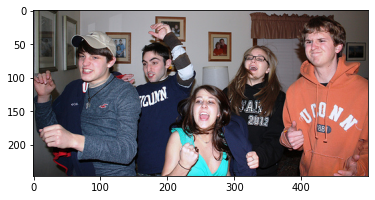

Greedy: a man and a woman are posing for a picture
Beam Search, K = 3: a group of people are posing for a picture in front of a building
Beam Search, K = 5: a group of people posing for a picture
Beam Search, K = 7: a group of people posing for a picture


In [61]:
pic = list(encoding_test.keys())[15]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))

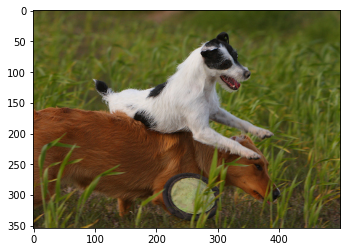

Greedy: a brown and white dog is running through a field
Beam Search, K = 3: a brown and white dog is chasing a ball in its mouth
Beam Search, K = 5: a brown and white dog is playing with a soccer ball in the grass
Beam Search, K = 7: a brown and white dog is attempting to catch a tennis ball in its mouth


In [60]:
pic = list(encoding_test.keys())[121]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))

The captions generated are not perfect as we have limited the epochs and training time.  